# History Kaggle: Airbnb New User Bookings

## Goal: Predict the destination country of a new user's first booking on Airbnb.

## Outline:

1. Download 5 data files
2. Build a fast benchmark model with basic training data
3. Add more features from background data
4. Build new model with engineered feature
5. Tune model

## Download data
Data for this project are downloaded from the following link:<br/>
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

We are given demographics of users (train_users.csv, test_users.csv), records of users' web sessions (sessions.csv) as well as some basic information (age_gender_bkts.csv, countries.csv) as input datasets.

In [1]:
import warnings
warnings.filterwarnings('ignore')    # suppress warnings for clean demo

pd.set_option('display.max_rows', None)    #don't hide any rows or columns when display
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
import datetime

from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

### Load Datasets (5 files in total)

#### Users datasets (2 files)

Training users dataset contains information of users that created their account between January 1, 2010 and July 1, 2014, while testing users dataset consists of users that first active between July 1, 2014 and December 5, 2015.

In [2]:
train_users_data = pd.read_csv("train_users_2.csv")

In [3]:
train_users_data.head(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


In [4]:
train_users_data.loc[:,'date_account_created'] = pd.to_datetime(train_users_data.date_account_created)

In [5]:
train_short_index = train_users_data.date_account_created >= pd.to_datetime('2012-07-01 00:00:00', format='%Y-%m-%d %H:%M:%S')

In [6]:
train_short_index.sum()

183537

In [7]:
train_short = train_users_data[train_short_index]

In [8]:
train_short.loc[:,'date_account_created'] = train_short.date_account_created.apply(lambda x: pd.to_datetime(x.strftime('%x')))

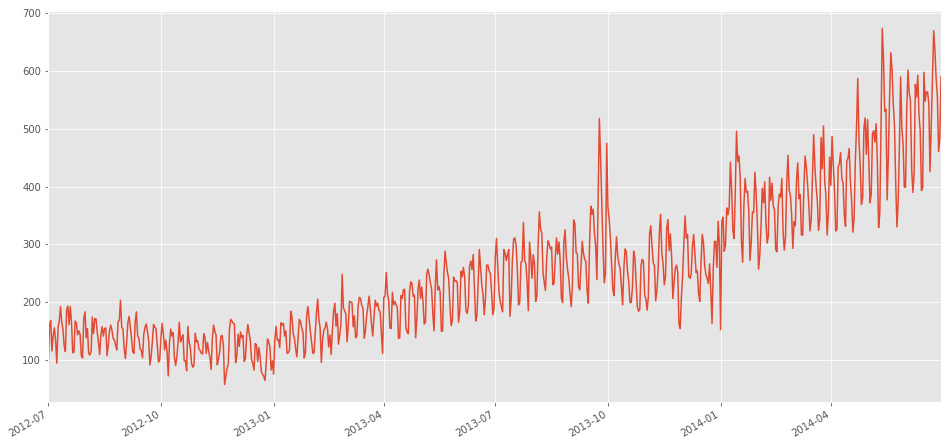

In [9]:
fig, ax = plt.subplots(figsize = (16, 8));
train_short.date_account_created.value_counts().plot();

In [10]:
train_short.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [11]:
train_short.drop(['timestamp_first_active','signup_method', 'language','date_first_booking', 'affiliate_provider', 'first_affiliate_tracked', 'signup_flow', 'first_device_type', 'first_browser'], axis = 1, inplace = True)

In [12]:
train_short.columns

Index(['id', 'date_account_created', 'gender', 'age', 'affiliate_channel',
       'signup_app', 'country_destination'],
      dtype='object')

In [13]:
len(train_short.columns)

7

In [14]:
train_short['Booking'] = (train_short.country_destination != 'NDF')

In [15]:
train_short.drop('country_destination', axis = 1, inplace = True)

In [16]:
train_short.head(5)

,id,date_account_created,gender,age,affiliate_channel,signup_app,Booking
422,oamfblpxdy,2014-01-15,OTHER,45.0,direct,Moweb,True
710,5p0nmf3r6i,2014-05-23,FEMALE,39.0,direct,Web,False
1025,dlg3a9x97v,2014-04-03,MALE,47.0,sem-brand,Web,False
2446,3z2djcpw50,2013-03-22,-unknown-,34.0,direct,Web,True
2537,m1x72dgnnk,2013-08-22,FEMALE,38.0,direct,Web,True


In [17]:
train_short.to_csv("airbnb_short.csv", index = False)

In [18]:
tmp_df = pd.read_csv("airbnb_short.csv")

In [19]:
tmp_df.head(10)

,id,date_account_created,gender,age,affiliate_channel,signup_app,Booking
0,oamfblpxdy,2014-01-15,OTHER,45.0,direct,Moweb,True
1,5p0nmf3r6i,2014-05-23,FEMALE,39.0,direct,Web,False
2,dlg3a9x97v,2014-04-03,MALE,47.0,sem-brand,Web,False
3,3z2djcpw50,2013-03-22,-unknown-,34.0,direct,Web,True
4,m1x72dgnnk,2013-08-22,FEMALE,38.0,direct,Web,True
5,x1dufb5trn,2013-09-26,FEMALE,NaN,sem-brand,Web,False
6,p4oev43bwu,2014-02-11,-unknown-,27.0,sem-brand,Web,True
7,spnpzaf7mz,2012-12-18,MALE,43.0,direct,Web,False
8,yq0umtehh9,2013-04-03,MALE,48.0,direct,Web,False
9,lc6kyl74zt,2012-09-16,MALE,64.0,direct,Web,True
